<a href="https://colab.research.google.com/github/Jack3690/DDA/blob/main/GalFit_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization**


In [2]:
!pip install astroquery --quiet
!pip install sep --quiet
!pip install photutils --quiet

     |████████████████████████████████| 4.5 MB 7.7 MB/s 
     |████████████████████████████████| 885 kB 43.1 MB/s 
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 4.0 MB 58.1 MB/s 
     |████████████████████████████████| 1.2 MB 9.2 MB/s 
     |████████████████████████████████| 873 kB 8.9 MB/s 
     |████████████████████████████████| 11.4 MB 56.2 MB/s 


In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sb
from astroquery.sdss import SDSS
from astroquery.skyview import SkyView
from astroquery.simbad import Simbad
from astroquery.ned import Ned

from astropy import coordinates as coords
import astropy.units as u
from astropy.io import fits
from matplotlib import colors as col
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel
from astropy.table import Table
from photutils.aperture import aperture_photometry
import copy

import sys
import requests

if sys.version_info.major == 2:
    from cStringIO import StringIO as stringio
else:
    from io import StringIO as stringio
    from io import BytesIO as bytesio

import photutils as phot
from photutils import aperture as aper 
from photutils.segmentation import deblend_sources
import sep

# To plot pretty figures
%matplotlib inline
#%matplotlib notebook

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (15,8)

<ipython-input-3-bc2f905d58ec>:8: DeprecationWarning: the ``ned`` module has been moved to astroquery.ipac.ned, please update your imports.
  from astroquery.ned import Ned


In [4]:
os.system('wget https://users.obs.carnegiescience.edu/peng/work/galfit/galfit3-debian64.tar.gz')
os.system('tar -xvf galfit3-debian64.tar.gz')
os.system('rm galfit3-debian64.tar.gz')

0

In [5]:
os.system('wget https://data.sdss.org/sas/dr17/env/MANGA_PHOTO/pymorph/1.1.1/manga-pymorph-DR17.fits')

0

## **SDSS PSF Extract and  Image Preparation**

In [6]:
def reconstructPSF(psFieldFilename, filter, row, col, trim = True,download_fits = True):
  
  filterIdx = 'ugriz'.index(filter) + 1
  psField = fits.open(psFieldFilename)
  pStruct = psField[filterIdx].data
  header  = psField[filterIdx].header

  nrow_b = pStruct['nrow_b'][0]
  ncol_b = pStruct['ncol_b'][0]

  rnrow = pStruct['rnrow'][0]
  rncol = pStruct['rncol'][0]

  nb = nrow_b * ncol_b
  coeffs = np.zeros(nb.size, float)
  ecoeff = np.zeros(3, float)
  cmat = pStruct['c']

  rcs = 0.001
  for ii in range(0, nb.size):
      coeffs[ii] = (row * rcs)**(ii % nrow_b) * (col * rcs)**(ii / nrow_b)

  for jj in range(0, 3):
      for ii in range(0, nb.size):
          ecoeff[jj] = ecoeff[jj] + cmat[int(ii / nrow_b), ii % nrow_b, jj] * coeffs[ii]

  psf = pStruct['rrows'][0] * ecoeff[0] + \
      pStruct['rrows'][1] * ecoeff[1] + \
      pStruct['rrows'][2] * ecoeff[2]

  psf = np.reshape(psf, (rnrow, rncol))
  if trim:
    psf = psf[10:40, 10:40]  # Trim non-zero regions.
  if download_fits:
    hdu = fits.PrimaryHDU(data = psf, header = header )
    hdul = fits.HDUList(hdu)
    hdul.writeto(f'psf_{filter}.fits',overwrite = True)

  return psf

## **GalFit Wrap**

In [7]:
def init(ra= None, dec = None, run = None, params=None):
  # Resolving source
  url = f"https://skyserver.sdss.org/dr17/SkyServerWS/SDSSFields/FieldArray?ra={ra}&dec={dec}&radius=5&format=csv"
  response = requests.get(url)
  global df
  df = pd.read_csv(bytesio(response.content), skiprows = 1)
  if run in df.run:
    print(run,'Found!')
    params = df[df['run']==run]
  elif params is not None:
    params = params
  else:
    params = df.head(1)
    print(params.run)
  run    = params['run'].values[0]
  camcol = params['camcol'].values[0]
  field  = params['field'].values[0]
  rerun  = params['rerun'].values[0]
  print("Downloading Images")
  pos = coords.SkyCoord(f'{ra} {dec}', unit=(u.deg, u.deg),frame='icrs')
  galimg_g, mask_g = image_gen(pos= pos, params = params,band = 'g')
  galimg_r, mask_r = image_gen(pos= pos, params = params,band = 'r')
  galimg_i, mask_i = image_gen(pos= pos, params = params,band = 'i')
  print("Download Complete")
  # Run in SDSS SAS
  if ra is not None:
    galimg = np.concatenate((galimg_g,galimg_r,galimg_i), axis =0)
    mask   = np.concatenate((mask_g,mask_r,mask_i), axis =0)
    
    filename = f"psField-00{run}-{camcol}-00{field}.fit"

    if len(str(field)) ==3:
      filename = f"psField-00{run}-{camcol}-0{field}.fit"

    # Download psField file
    if not os.path.exists(filename):
      url = f"https://data.sdss.org/sas/dr17/eboss/photo/redux/{rerun}/{run}/objcs/{camcol}/{filename}"
      print(url)
      status = os.system(f'!wget {url}')
      os.system(f'wget {url}')


    # Reconstruct PSF
    psf_g   = reconstructPSF(filename,'g',1000,1000)
    psf_r   = reconstructPSF(filename,'r',1000,1000)
    psf_i   = reconstructPSF(filename,'i',1000,1000)

    psf = np.concatenate((psf_g,psf_r,psf_i), axis =0)
    models = None# model_init(source, galimg_g.shape,pscale = 0.396, bands = ['g','r','i'])

    return galimg, mask, psf, models

def image_gen( pos=None, params = None,band = 'g') :

  count = 0
  if params is not None:
    url = params[f'{band}_url'].values[0]
    filename = url.split('/')[-1]
    if not os.path.exists(filename):
      os.system(f'wget {url}')
    
    hdul = fits.open(filename)

  hdu  = hdul[0]
  wcs  = WCS(hdu.header)

  cutout = Cutout2D(hdu.data,pos,size = [128,128], wcs = wcs)
  cutout.wcs.wcs.crpix = [63, 63]
  header_new = cutout.wcs.to_header()

  hdu.data = cutout.data/hdu.header['NMGY']  +1000        # Counts
  hdu.header.update(header_new)
  hdu.header['GAIN']     = 3.0
  hdu.header['EXPTIME']  = 1.0
  hdu.header['RDNOISE '] = 4.5
  hdu.header['NCOMBINE'] = 1.0
  hdu.header['ZPT']      = 22.5 - 2.5*np.log10(hdu.header['NMGY'])
  hdu.header['BUNIT']    = "ADU"

  hdu.writeto(f'gal_{band}.fits',overwrite = True)

  mask = generate_mask(hdu)
  hdu_m = fits.PrimaryHDU(data = mask)
  hdul = fits.HDUList(hdu_m)
  hdul.writeto(f'mask_{band}.fits',overwrite = True)
  return hdu.data, hdu_m.data

def model_init(source, shape, pscale, bands = ['g','r','i'] ):
  plateifu = source[6:]
  cats = [ Table.read('/content/manga-pymorph-DR17.fits',hdu = i )for i in range(1,4)]
  models = {}
  for band in bands :
    cat = cats[bands.index(band)]
    row = cat[cat['PLATEIFU']==plateifu]
    if len(row)==0:
      mangaid = source[6:]
      row     = cat[cat['MANGA_ID']==mangaid]
    if len(row)!=0:
      models[f'models_{band}'] = []
      model = {}
                                                    
      model[0] = 'sersic'                               #  object type
      model[1] = f'{shape[0]//2} {shape[0]//2} 1 1'     #  position x, y
      model[3] = f"{row['M_SE_BULGE'].value[0]} 1"      #  Integrated magnitude   
      model[4] = f"{row['A_HL_SE_BULGE'].value[0]/pscale} 1"   #  R_e (half-light radius)[pix]
      model[5] = f"{row['N_SE_BULGE'].value[0]} 1"      #  Sersic index n (de Vaucouleurs n=4) 
      model[9] = f"{row['BA_SE_BULGE'].value[0]} 1"     #  axis ratio (b/a)  
      model[10]= f"{row['PA_SE_BULGE'].value[0]} 1"     #  position angle (PA) [deg: Up=0, Left=90]
      model['Z'] = 0                                    #  output option (0 = resid., 1 = Don't subtract

      models[f'models_{band}'].append(model)
      model = copy.deepcopy(model)

      model[3] = f"{row['M_SE_BULGE'].value[0]} 1"
      model[4] = f"{row['A_HL_SE_BULGE'].value[0]/(pscale)*2} 1"
      model[5] = f"{0.5} 1"
      model[9] = f"{0.3} 1"

      models[f'models_{band}'].append(model)
      model = copy.deepcopy(model)

      model[0] = 'expdisk'
      model[1] = f"{shape[0]//2} {shape[0]//2} 1 1"
      model[3] = f"{row['M_SE_DISK'].value[0]} 1"
      model[4] = f"{row['A_HL_SE_DISK'].value[0]/(pscale)} 1"
      del model[5]
      model[9] = f"{row['BA_SE_DISK'].value[0]} 1"
      model[10]= f"{row['PA_SE_DISK'].value[0]} 1"
      model['Z'] = 0
      models[f'models_{band}'].append(model)

      model = {}
      model[0]= 'sky'
      model[1]= '1000 1'
      model['Z'] = 0

      models[f'models_{band}'].append(model)
    else:
          models={'models_g': [{0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '17.8 1',
                4: '13.2376 1',
                5: '0.3199 1',
                9: '0.3738 1',
                'Z': 0},
                {0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '18.8 1',
                4: '6 1',
                5: '1.3634 1',
                9: '0.4 1',
                'Z': 0},
                {0: 'expdisk',
                1: '64 64 1 1',
                10: '-65  1',
                3: '19.5 1',
                4: '100 1',
                9: '0.3 1',
                'Z': 0},
                {0: 'sky', 1: '1000 1', 'Z': 0}],
              'models_r': [{0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '19.0243 1',
                4: '13.2376 1',
                5: '0.3199 1',
                9: '0.3738 1',
                'Z': 0},
                {0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '18.9396 1',
                4: '6 1',
                5: '1.3634 1',
                9: '0.4 1',
                'Z': 0},
                {0: 'expdisk',
                1: '64 64 1 1',
                10: '-73.3458  1',
                3: '18 1',
                4: '40 1',
                9: '0.3 1',
                'Z': 0},
                {0: 'sky', 1: '1000 1', 'Z': 0}],
              'models_i': [{0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '17.0243 1',
                4: '13.2376 1',
                5: '0.3199 1',
                9: '0.3738 1',
                'Z': 0},
                {0: 'sersic',
                1: '64 64 1 1',
                10: '-73 1',
                3: '17.9396 1',
                4: '6 1',
                5: '1.3634 1',
                9: '0.4 1',
                'Z': 0},
                {0: 'expdisk',
                1: '64 64 1 1',
                10: '-73.3458  1',
                3: '16 1',
                4: '40 1',
                9: '0.3 1',
                'Z': 0},
                {0: 'sky', 1: '1000 1', 'Z': 0}]}

  return models


def generate_mask(hdu):

  wcs = WCS(hdu.header)
  data = hdu.data
  #data = data.byteswap().newbyteorder()
  bkg = sep.Background(data,bh=64,bw=64,fh=3,fw=3)
  bkg_image = bkg.back()
  bkg_rms = bkg.rms()

  sigma = 3.0 * 0.42466090014400953  # FWHM = 3.

  kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
  kernel.normalize()

  threshold = bkg.back() + (3.0 * bkg.rms())

  segm = phot.detect_sources(data, threshold, npixels=5, kernel=kernel)
  segm_deblend = deblend_sources(data, segm, npixels=5,
                               nlevels=32, contrast=0.001)
  segm_deblend = segm
  if len(segm_deblend.areas)>1:
    ind = np.where(segm_deblend.areas!=segm_deblend.areas.max())[0]+1
    segm_deblend.keep_labels(ind)
    mask = np.where(segm_deblend.data>0,1,0)
  else:
    mask = data*0
  return mask

def show_image(oimgs, modss, bands=['g','r','i']):
  fig, ax = plt.subplots(3,6, figsize = (35,20))
  colors = ['red','green','blue','orange','orange','orange']
  models = ['sersic','sersic','expdisk','sersic','sersic','sersic']
  for j, band in enumerate(bands):

    mask = fits.open(f'mask_{band}.fits')[0].data
    data_s = oimgs[j][1].data
    masked_data = np.ma.masked_array(data = data_s, mask = mask)
    ax[j][0].imshow(data_s,cmap = 'jet')
    mods = modss[j]

    for i in range(1,4):
      data = oimgs[j][i].data
      masked_data = np.ma.masked_array(data = data, mask = mask)

      ax[j][i].imshow(masked_data, cmap = 'jet')

    ax[j][4].imshow(data_s, cmap = 'gray',norm = col.LogNorm())
    
    apertures = aperture_gen(mods[:-1])
    for k, aperture in enumerate(apertures):
      apertures[aperture].plot(ax[j][4],color = colors[k], label = models[k])

    ax[j][4].legend()
    ax[j][5].hist(masked_data.ravel())
    ax[j][5].grid(False)
    ax[j][5].set_yscale('log')

    ax[j][0].set_title(f'Source | {band} band')
    ax[j][1].set_title(f'Masked Source | {band} band')
    ax[j][2].set_title(f'Masked Model | {band} band')
    ax[j][3].set_title(f'Masked Residual | {band} band')
    ax[j][4].set_title(f'Apertures on Source | {band} band')
    ax[j][5].set_title(f'Masked Residual Hist | {band} band')
  fig.suptitle('GalFit', y = 0.91,fontsize = 20)
  plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
  plt.show();

def aperture_gen(models):
  apertures = {}
  for i,model in enumerate(models):

    X_c = model[f'{i+1}_XC'].split('+')[0]
    if '*' in X_c or '[' in X_c:
      print('Error in X_c')
      X_c = float(X_c[1:-2])
    else:
      X_c = float(X_c)

    Y_c = model[f'{i+1}_YC'].split('+')[0]
    if '*' in Y_c or '[' in Y_c:
      print('Error in Y_c')
      Y_c = float(Y_c[1:-2])
    else:
      Y_c = float(Y_c)

    PA = model[f'{i+1}_PA'].split('+')[0]
    if '*' in PA or '[' in PA:
      print('Error in PA')
      PA = float(PA[1:-2])
    else:
      PA = float(PA)

    AR = model[f'{i+1}_AR'].split('+')[0]
    if '*' in  AR or '[' in AR:
      print('Error in AR')
      AR = float(AR[1:-2])
    else:
      AR = float(AR)

    keys = [i.split('_')[-1] for i in model.keys()]
    if'RE' in keys:
      RE = model[f'{i+1}_RE'].split('+')[0]
      if '*' in RE or '[' in RE:
        print('Error in X_c')
        RE = float(RE[1:-2])
      else:
        RE = float(RE)

    else:
      RE = model[f'{i+1}_RS'].split('+')[0]
      if '*' in RE or '[' in RE:
        print('Error in RS')
        RE = float(RE[1:-2])
      else:
        RE = float(RE)

    a = 2*RE
    b = AR*a
    aperture = aper.EllipticalAperture((X_c-1,Y_c-1), a,b,theta = np.pi/2 + (PA)*np.pi/180)
    apertures[f'aper_{i+1}'] = aperture
  return apertures


In [8]:
from subprocess import Popen, PIPE
from scipy.signal import fftconvolve

def CreateFile(Iimg, region, models, outfile = 'out.fits',sky='Default', fout=None, **kwargs):
    '''
        Creates a file to be run with galfit
        options can be given through kwargs
        models is a list of dicts where the keys are the model parameters.
        Note that region includes the initial pixel, ie, a box from 200 to 300 will have 101 pixels, in python this will be a[199:300]
        Example sersic model:
        {
         0  : 'sersic',      #  object type
         1  : '250 490 1 1', #  position x, y
         3  : '12. 1',       #  Integrated magnitude
         4  : '9 1',         #  R_e (half-light radius)   [pix]
         5  : '1.5 1',       #  Sersic index n (de Vaucouleurs n=4)
        'c0': '0 1',         #  Boxyness
         9  : '1 1',         #  axis ratio (b/a)
        10  : '0 1',         #  position angle (PA) [deg: Up=0, Left=90]
        'Z' :  0}            #  output option (0 = resid., 1 = Don't subtract)
        PLEASE be aware that if filenames are too long galfit will dump core! (psffile specifically!)
    '''
    if len(models) == 0:
        print('Need at least one model!')
        return 1
    defdict = {
        'Iimg': Iimg,  # Input data image (FITS file)
        'Oimg': outfile,  # Output data image block
        'Simg': '',  # Sigma Image
        'Pimg': 'none',  # PSF Image
        'PSFf': '1',  # PSF fine sampling factor
        'badmask': 'none',  # Bad pixel mask (FITS image or ASCII coord list)'
        'constr': 'none',  # File with parameter constraints (ASCII file) '
        'region': '{0} {1} {2} {3}'.format(region[0], region[1], region[2], region[3]), # Image region to fit (xmin xmax ymin ymax)'
        'convbox': '100 100',  # Size of the convolution box (x y)'
        'ZP': '0',  # Magnitude photometric zeropoint '
        'scale': '0.03 0.03',  # Plate scale (dx dy)    [arcsec per pixel]'
        'dispt': 'regular',  # Display type (regular, curses, both)'
        'opt': '0',  # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps'
    }
    defdict.update(kwargs)

    fout = open(fout, 'w')
    fout.write('A) {0} \n'.format(defdict['Iimg']))
    fout.write('B) {0} \n'.format(defdict['Oimg']))
    fout.write('C) {0} \n'.format(defdict['Simg']))
    fout.write('D) {0} \n'.format(defdict['Pimg']))
    fout.write('E) {0} \n'.format(defdict['PSFf']))
    fout.write('F) {0} \n'.format(defdict['badmask']))
    fout.write('G) {0} \n'.format(defdict['constr']))
    fout.write('H) {0} \n'.format(defdict['region']))
    fout.write('I) {0} \n'.format(defdict['convbox']))
    fout.write('J) {0} \n'.format(defdict['ZP']))
    fout.write('K) {0} \n'.format(defdict['scale']))
    fout.write('O) {0} \n'.format(defdict['dispt']))
    fout.write('P) {0} \n'.format(defdict['opt']))

    emodels = list(models)
    if 'sky' not in [a[0] for a in emodels]:
        if sky=='Default':
            sky = {0: 'sky', 1: '1 1', 2: '0 0',
                   3: '0 0', 'Z': 0, 'Comment': 'StandardSky'}
        if sky!='None':
            emodels.append(sky)
    for model in emodels:
        for i in np.argsort(list(model.keys())):
            key = list(model.keys())[i]
            s='{0}) {1} \n'.format(key, model[key])
            if key in ['Comment','mskidx','origin']:s='#'+s
            fout.write(s)
    fout.close()
    return 0

def rungalfit(infile, outfile='out.fits', timeout=600, verb=True):
    # galfit needs to be in the path
    # will run here, so file either needs to be complete path, or here...
    Popen(["rm", outfile], stderr=PIPE)
    p     = Popen(["timeout", str(timeout), "./galfit", infile], stdout=PIPE)
    ES    = p.wait()
    pout  = p.stdout.readlines()
    if ES == 124:
        if verb:
            for l in pout:
                print( l[:-1])
        if verb:
            print('Process timeout...')
        return pout, [-1, -1, -1, -1], [], 124
    try:
        outfit = fits.open(outfile)
        if len(outfit)==1:
            imgi = 0
            if verb: print('Only the model was found, no fitting perfomed')
        else: imgi=2
        models = []
        for mod in [x for x in outfit[imgi].header if 'COMP' in x]:
            models.append({mod: outfit[imgi].header[mod]})
            for key in [x for x in outfit[imgi].header if mod[5:]+'_' in x]:
                if verb:
                    print(key, outfit[imgi].header[key])
                models[-1][key] = outfit[imgi].header[key]
        return pout, outfit, models, 0
    except Exception as E:
        if verb:
            for l in pout:
                print( l[:-1])
        if verb:
            print(E)
        if verb:
            print('something went wrong...')
        return pout, [-1, -1, -1, -1], [], 1

def maskfiles(sci, msk, wht=None, fout=["tsci.fits", "twht.fits"], verb=True):
    overify='fix' if verb else 'silentfix'
    Popen(["rm", fout[0]], stderr=PIPE)
    scifits = fits.open(sci)
    scifits[0].data *= msk
    scifits.writeto(fout[0], clobber=True,output_verify=overify)
    scifits.close()
    if wht is not None:
        Popen(["rm", fout[1]], stderr=PIPE)
        whtfits = fits.open(wht)
        whtfits[0].data *= msk
    else:
        wht=np.zeros(msk.shape)
        wht[msk!=1]=1
        whtfits = fits.HDUList([fits.PrimaryHDU(wht)])
    whtfits.writeto(fout[1], clobber=True,output_verify=overify)
    whtfits.close()
    return fout

In [9]:
def isit(A):
    #Return True if A is iterable
    try:
        iter(A)
    except:
        return False
    return True

def middlebin(A):
    #Return the middle bin of an array
    return (A[1:]+A[:-1])*0.5

def getWP(D,w,p=None):
    from scipy.interpolate import interp1d
    #Gets percentile p for array D with weights w
    #if p is none, interpolator is return
    #p is given in percentage
    #Normalize
    w=np.array(w)
    w/=np.sum(w)/100
    #Sort ascending
    idxs=np.argsort(D)
    w=w[idxs]
    #Cumulative to find percentile
    C=np.cumsum(w)
    C=middlebin(np.append([0.],C))
    C[0]=0.
    C[-1]=100.

    # C=np.cumsum(w[1:])
    # C=np.append([0],C)

    # Interpolator between Cumulative Sum and value of A
    it=interp1d(C,np.array(D)[idxs])
    if p is None:
        return it
    else:
        return it(p)

def getContours(H,l,E=None):
    """
        Assumes H is well shown with plt.imshow(H,origin="lower",extent=E)
    """
    # H=np.flipud(H)
    # from matplotlib import _cntr as cntr
    from skimage import measure
    if E is None:
        E=[0,H.shape[1],0,H.shape[0]]
    locx=middlebin(np.linspace(E[0],E[1],H.shape[1]+1,endpoint=True))
    locy=middlebin(np.linspace(E[2],E[3],H.shape[0]+1,endpoint=True))
    y, x = np.mgrid[:H.shape[0], :H.shape[1]]

    contours = measure.find_contours(H, l)

    # c = cntr.Cntr(x, y, H)
    # res = c.trace(l)
    # nseg = len(res) // 2
    # segments, codes = res[:nseg], res[nseg:]
    toret=[]
    for seg in contours:
        x=np.interp(seg[:,1],range(H.shape[1]),locx)
        y=np.interp(seg[:,0],range(H.shape[0]),locy)
        toret.append(np.array([x,y]).T)
    S=np.array(toret)
    return S

In [156]:
def extract(mods, freeze = False):
  if freeze:
    f = 0
  else:
    f = 1
  mod_list = []
  for i,comp in enumerate(mods):
    i +=1
    mod_dict = {}
    mod_dict[0] = comp[f'COMP_{i}']

    if mod_dict[0]!= 'sky':
      mod_dict[1] = f"{comp[f'{i}_XC'].split()[0]} {comp[f'{i}_YC'].split()[0]} {f} {f}"
      mod_dict[3] = f"{comp[f'{i}_MAG'].split()[0]} {f}"

      if mod_dict[0]== 'expdisk':
        mod_dict[4] = f"{comp[f'{i}_RS'].split()[0]} {f}"
      else:
        mod_dict[4] = f"{comp[f'{i}_RE'].split()[0]} {f}"
        mod_dict[5] = f"{comp[f'{i}_N'].split()[0]} {f}"

      mod_dict[9] = f"{comp[f'{i}_AR'].split()[0]} {f}"
      mod_dict[10] = f"{comp[f'{i}_PA'].split()[0]} {f}"

    else:
      mod_dict[1] = f"{comp[f'{i}_SKY'].split()[0]} {f}"

    mod_dict['Z'] = 0

    mod_list.append(mod_dict)
  return mod_list

# **Data**


In [10]:
run    = 4849
camcol = 4
rerun  = 301
field  = '788'
dr     = 12

ra,  dec = 49.973226, 0.391442

params           = pd.DataFrame([run], columns = ['run'])
params['run']    = run
params['camcol'] = camcol
params['rerun']  = rerun
params['field']  = field

params['g_url']  = f"https://dr{dr}.sdss.org/sas/dr{dr}/boss/photoObj/frames/{rerun}/{run}/{camcol}/frame-g-00{run}-{camcol}-0{field}.fits.bz2"
params['r_url']  = f"https://dr{dr}.sdss.org/sas/dr{dr}/boss/photoObj/frames/{rerun}/{run}/{camcol}/frame-r-00{run}-{camcol}-0{field}.fits.bz2"
params['i_url']  = f"https://dr{dr}.sdss.org/sas/dr{dr}/boss/photoObj/frames/{rerun}/{run}/{camcol}/frame-i-00{run}-{camcol}-0{field}.fits.bz2"

In [11]:
params

,run,camcol,rerun,field,g_url,r_url,i_url
0,4849,4,301,788,https://dr12.sdss.org/sas/dr12/boss/photoObj/f...,https://dr12.sdss.org/sas/dr12/boss/photoObj/f...,https://dr12.sdss.org/sas/dr12/boss/photoObj/f...


In [ ]:
ids = ['8083-3702','8335-6101','8453-3704','8600-1901','10840-3701','10215-3704'
                               ,'9181-9101','9049-3704','9488-6101','7965-1901']
galimg, mask, psf, models_ = init(ra = ra, dec = dec, params = params)	

0  : 'sersic',      #  object type <br>
         1  : '250 490 1 1', #  position x, y<br>
         3  : '12. 1',       #  Integrated magnitude<br>
         4  : '9 1',         #  R_e (half-light radius)   [pix]<br>
         5  : '1.5 1',       #  Sersic index n (de Vaucouleurs n=4)<br>
        'c0': '0 1',         #  Boxyness<br>
         9  : '1 1',         #  axis ratio (b/a)<br>
        10  : '0 1',         #  position angle (PA) [deg: Up=0, Left=90]<br>
        'Z' :  0}            #  output option (0 = resid., 1 = Don't subtract<br>

## **8083-3702**

In [ ]:
run    = 4849
camcol = 4
rerun  = 301
field  = '788'
dr     = 12

ra,  dec = 49.973226, 0.391442

In [157]:
#Define the model (as in galfit example):
models = {}
models['models_g'] = [

 {0: 'sersic',
   1: '64.1909 64.4151 1 1 ',
   10: '-44.3888        1',
   3: '19.4833          1',
   4: '4.0510           1',
   5: '0.1615           1',
   9: '0.3938           1',
   'Z': 0},

  {0: 'expdisk',
   1: '64.3525 64.4035  1 1',
   10: '0.2785 1',
   3: '17.8262  1',
   4: '7.0009  1',
   9: '0.8137  1',
   'Z': 0},

  {0: 'sky', 1: '1000 1', 'Z': 0}]

In [169]:
models['models_r'] =  [{0: 'sersic',
   1: '64.2251 64.4436 1 1',
   3: '18.1716 1',
   4: '4.2282 1',
   5: '0.8990 1',
   9: '0.3917 1',
   10: '-45.3407 1',
   'Z': 0},

  {0: 'expdisk',
   1: '65.4767 64.8183 1 1',
   3: '17.6233 1',
   4: '6.1615 1',
   9: '0.8560 1',
   10: '-13.8017 1',
   'Z': 0},

   {0: 'sersic',
   1: '67.6905 74.6697 1 1',
   10: '-42.2265   1',
   3: '20.9218     1',
   4: '1.1487      1',
   5: '0.7833      1',
   9: '0.9         1',
   'Z': 0},
  {0: 'sky', 1: '1000 1', 'Z': 0}]

In [158]:
models['models_i'] = [
     
  {0: 'sersic',
   1: '64.6017 64.6631 1 1 ',
   10: '-46.5915   1',
   3: '17.4303   1',
   4: '4.0261   1',
   5: '0.6707    1',
   9: '0.4682       1',
   'Z': 0},

  {0: 'expdisk',
   1: '65.7088  65.3181  1 1',
   10: '-15.1841 1',
   3: '16.4604   1',
   4: '6.4094  1',
   9: '0.8307  1',
   'Z': 0},

   {0: 'sersic',
   1: '67.6905 74.6697 1 1',
   10: '-62.4413    1',
   3: '19.9304     1',
   4: '1.1487      1',
   5: '0.7833      0',
   9: '0.9         0',
   'Z': 0},
  {0: 'sky', 1: '1000 1', 'Z': 0}]

# **Fitting**

In [173]:
bands = ['g','r','i']
ps    = []
oimgs = []
modss = []
EVs   = []

subcomp = False

for band in bands[:2]:
  
  ZPT = fits.open(f'gal_{band}.fits')[0].header['ZPT']

  if subcomp:
    m = models[f'models_{band}']
    for i in range(len(m)):
      m[i]['P'] = 3
      O = CreateFile(f'gal_{band}.fits', [1,128,1,128], badmask = f'mask_{band}.fits'
  , models = m,  outfile=f'subcomps.fits',
  fout = f'galfit_{band}.input',ZP=ZPT,Pimg=f'psf_{band}.fits',scale='0.396 0.396')
     
    p,oimg,mods,EV = rungalfit(f'galfit_{band}.input', outfile=f'subcomps.fits')
    hdul = fits.open('subcomps.fits')
    hdul.writeto(f'subcomps_{band}.fits', output_verify = 'ignore')
  else:
      O = CreateFile(f'gal_{band}.fits', [1,128,1,128], badmask = f'mask_{band}.fits'
      , models = models[f'models_{band}'],  outfile=f'out_{band}.fits',
       fout = f'galfit_{band}.input',ZP=ZPT,Pimg=f'psf_{band}.fits',scale='0.396 0.396')
      p,oimg,mods,EV = rungalfit(f'galfit_{band}.input', outfile=f'out_{band}.fits')

  ps.append(p)
  oimgs.append(oimg)
  modss.append(mods)
  EVs.append(EV)
  os.system('rm galfit.01' )

1_XC [0.000e+00]
1_YC [0.000e+00]
1_MAG [0.000e+00]
1_RE [0.000e+00]
1_N [0.000e+00]
1_AR [1.0000]
1_PA [0.000e+00]
2_XC [0.000e+00]
2_YC [0.000e+00]
2_MAG [0.000e+00]
2_RS [0.000e+00]
2_AR [1.0000]
2_PA [0.000e+00]
3_XC [64.5000]
3_YC [64.5000]
3_SKY [0.000e+00]
3_DSDX [0.000e+00]
3_DSDY [0.000e+00]
1_XC 64.3885 +/- 0.0161
1_YC 64.5000 +/- 0.0160
1_MAG 17.5630 +/- 0.0195
1_RE 3.9130 +/- 0.0464
1_N 0.9625 +/- 0.0238
1_AR 0.4241 +/- 0.0048
1_PA -46.3218 +/- 0.4298
2_XC 65.3563 +/- 0.0479
2_YC 64.7853 +/- 0.0618
2_MAG 16.8595 +/- 0.0091
2_RS 6.2496 +/- 0.0972
2_AR 0.8454 +/- 0.0075
2_PA -9.2317 +/- 2.8822
3_XC 67.6662 +/- 0.0581
3_YC 74.6859 +/- 0.0595
3_MAG 20.9424 +/- 0.1316
3_RE 1.1642 +/- 0.2458
3_N 0.5043 +/- 0.8215
3_AR 0.1472 +/- 0.7751
3_PA -63.8174 +/- 8.2405
4_XC [64.5000]
4_YC [64.5000]
4_SKY 1000.0828 +/- 0.0381
4_DSDX [0.000e+00]
4_DSDY [0.000e+00]


Error in X_c
Error in Y_c
Error in PA
Error in AR
Error in X_c


ValueError: ignored

/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


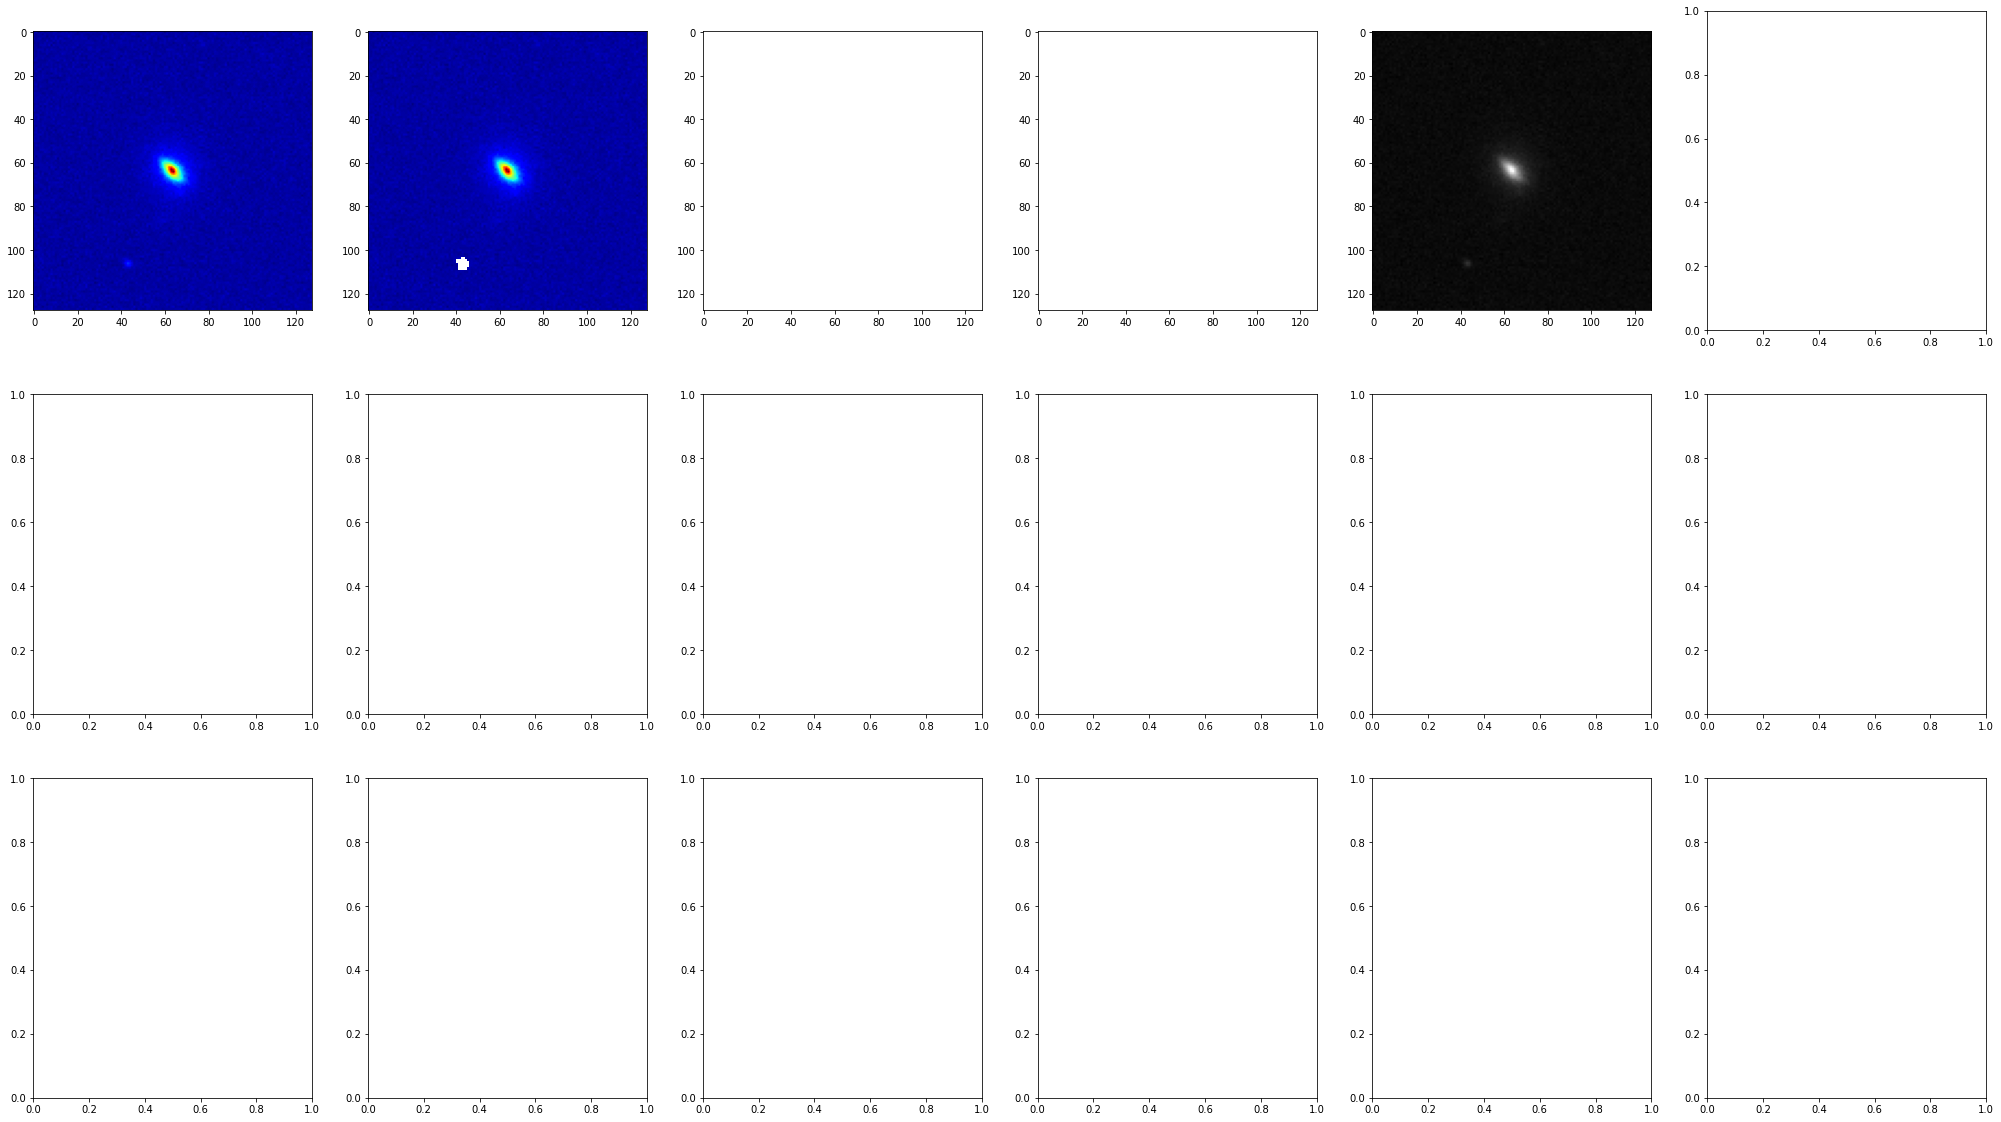

In [174]:
show_image(oimgs, modss, bands[:2])

In [172]:
models = {'models_g' : extract(modss[0], True),
          'models_r' : extract(modss[1]),
          #'models_i' : extract(modss[2])
          }

In [ ]:
import json
with open('10840-3701.json', 'w') as fout:
    json.dump(modss, fout)

In [ ]:
import json

In [ ]:
with open('10840-3701.json', 'r') as fout:
  m = json.load(fout)

In [ ]:
m

[[{'1_AR': '[0.6076]',
   '1_MAG': '[20.4140]',
   '1_N': '[8.2330]',
   '1_PA': '[-26.7849]',
   '1_RE': '[1.1213]',
   '1_XC': '[63.7044]',
   '1_YC': '[64.5196]',
   'COMP_1': 'sersic'},
  {'2_AR': '0.3341 +/- 0.0099',
   '2_MAG': '18.5973 +/- 0.0291',
   '2_N': '0.4520 +/- 0.0263',
   '2_PA': '88.0411 +/- 0.6667',
   '2_RE': '4.1343 +/- 0.0564',
   '2_XC': '65.5883 +/- 0.0595',
   '2_YC': '64.4493 +/- 0.0238',
   'COMP_2': 'sersic'},
  {'3_AR': '0.7777 +/- 0.0206',
   '3_MAG': '18.4733 +/- 0.0199',
   '3_PA': '25.6565 +/- 4.8123',
   '3_RS': '4.9067 +/- 0.2448',
   '3_XC': '65.6306 +/- 0.1758',
   '3_YC': '64.5733 +/- 0.1443',
   'COMP_3': 'expdisk'},
  {'4_DSDX': '[0.000e+00]',
   '4_DSDY': '[0.000e+00]',
   '4_SKY': '1000.3210 +/- 0.0482',
   '4_XC': '[64.5000]',
   '4_YC': '[64.5000]',
   'COMP_4': 'sky'}],
 [{'1_AR': '[0.6076]',
   '1_MAG': '19.9238 +/- 0.0655',
   '1_N': '[1.8142]',
   '1_PA': '[-26.7849]',
   '1_RE': '[1.2789]',
   '1_XC': '[63.7044]',
   '1_YC': '[64.5196]',

In [ ]:
from astropy.visualization import make_lupton_rgb

In [ ]:
hdu_g = fits.open('gal_g.fits')[0]
hdu_r = fits.open('gal_r.fits')[0]
hdu_i = fits.open('gal_i.fits')[0]

R = hdu_g.data 
G = hdu_r.data 
B = hdu_i.data 

R = (R- R.min())/(R.max()-R.min())
G = (G- G.min())/(G.max()-G.min())
B = (B- B.min())/(B.max()-B.min())

RGB = make_lupton_rgb(R,G,B )

In [ ]:
plt.imshow(G, cmap = 'jet', norm = col.LogNorm())